In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt


In [3]:

## redefine VAE architecture
class VAE2(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)  # mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # to output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        dec_output = self.decoder(z)
        return dec_output, mu, logvar


# Define VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)  # mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # to output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        dec_output = self.decoder(z)
        return dec_output, mu, logvar


In [4]:

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE(recon_x, x)
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence


In [5]:

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten images to vectors
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

# Initialize VAE
input_dim = 28*28
hidden_dim = 400
latent_dim = 20
vae = VAE(input_dim, hidden_dim, latent_dim)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)


In [4]:


# Training loop
num_epochs = 250
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (inputs, _) in enumerate(trainloader):
        
        
        inputs = inputs.cuda()  # Move inputs to GPU
        optimizer.zero_grad()
        vae.cuda()
        recon_batch, mu, logvar = vae(inputs)
        
#         print("Recon Batch Device:", recon_batch.device)
#         print("Inputs Device:", inputs.device)
#         print("Mu Device:", mu.device)
#         print("Logvar Device:", logvar.device)

        loss = vae_loss(recon_batch, inputs, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('Epoch {}, Loss: {:.4f}'.format(epoch+1, total_loss / len(trainloader)))
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(trainloader):
            inputs = inputs.cuda()
            recon_batch, _, _ = vae(inputs)
            predicted = torch.round(recon_batch)
            total += inputs.size(0)
            correct += (predicted == inputs).sum().item()

    accuracy = 100 * correct / total
    print("Accuracy: {:.2f}%".format(accuracy))
    
    

NameError: name 'trainloader' is not defined

In [3]:

import torch.distributions as dist

def generate_samples(vae, num_samples, distribution='gaussian'):
    if distribution == 'gaussian':
        z = torch.randn(num_samples, latent_dim).cuda()
    elif distribution == 'normal':
        z = torch.normal(mean=torch.ones(num_samples, latent_dim), std=2*torch.ones(num_samples, latent_dim)).cuda()
    elif distribution == 'beta':
        alpha = 2
        beta = 5
        z = torch.empty(num_samples, latent_dim).uniform_(0, 1).cuda()
        z = (z ** (1/alpha)) / ((1 - z) ** (1/beta))
    elif distribution == 'gamma':
        gamma_distribution = dist.gamma.Gamma(3, 2)
        z = gamma_distribution.sample((num_samples, latent_dim)).cuda()
    else:
        raise ValueError("Invalid distribution type")

    with torch.no_grad():
        generated_samples = vae.decoder(z)
    return generated_samples.view(-1, 1, 28, 28)

# Qualitative testing
num_samples = 10
gaussian_samples = generate_samples(vae, num_samples, 'gaussian')
normal_samples = generate_samples(vae, num_samples, 'normal')
beta_samples = generate_samples(vae, num_samples, 'beta')
gamma_samples = generate_samples(vae, num_samples, 'gamma')

NameError: name 'vae' is not defined

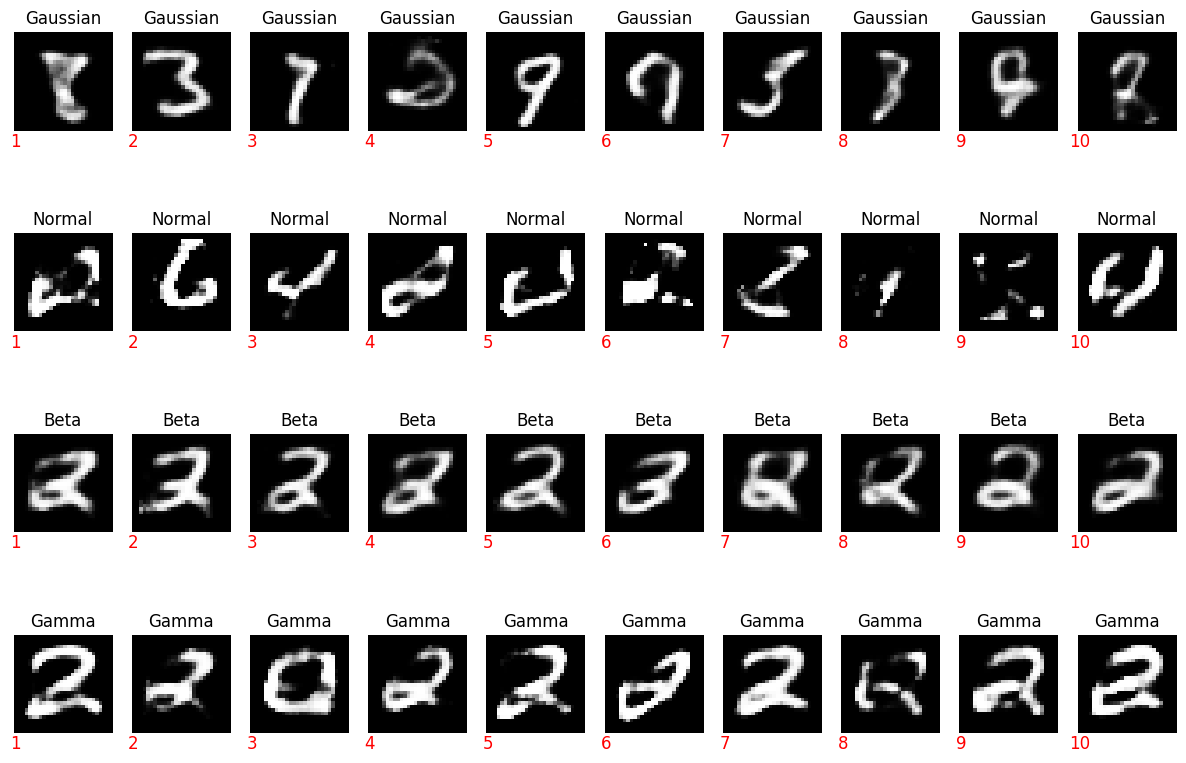

In [27]:
import matplotlib.pyplot as plt

# Define a function to plot generated samples with their labels
def plot_samples_with_labels(samples, labels, title, ax):
    num_samples = samples.shape[0]
    for i in range(num_samples):
        ax[i].imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        ax[i].text(0, 32, str(i+1), color='red', fontsize=12, ha='center')

        ax[i].set_title(labels[i])

# Plotting
fig, axs = plt.subplots(4, num_samples, figsize=(15, 10))
plot_samples_with_labels(gaussian_samples, ['Gaussian']*num_samples, 'Gaussian', axs[0])
plot_samples_with_labels(normal_samples, ['Normal']*num_samples, 'Normal', axs[1])
plot_samples_with_labels(beta_samples, ['Beta']*num_samples, 'Beta', axs[2])
plot_samples_with_labels(gamma_samples, ['Gamma']*num_samples, 'Gamma', axs[3])
plt.show()
